In [1]:
using DataFrames
using MixedModels
using StatsBase
using Gadfly
using CSV
using CategoricalArrays
using Colors

┌ Info: Precompiling MixedModels [ff71e718-51f3-5ec2-a782-8ffcbfa3c316]
└ @ Base loading.jl:1278
┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1278


In [2]:
function gen_brew_colors(n)
    cs = distinguishable_colors(n, 
        [colorant"#66c2a5", colorant"#fc8d62", colorant"#8da0cb", colorant"#e78ac3", 
            colorant"#a6d854", colorant"#ffd92f", colorant"#e5c494", colorant"#b3b3b3"],
        lchoices=Float64[58, 45, 72.5, 90],
        transform=c -> deuteranopic(c, 0.1),
        cchoices=Float64[20,40],
        hchoices=[75,51,35,120,180,210,270,310]
    )
    convert(Vector{Color}, cs)
end

gen_brew_colors (generic function with 1 method)

Import the data from Douven and Schupbach (2015a):

In [4]:
data = CSV.read("data.csv", DataFrame);

Add difference in explanatory goodness as well as identifiers for participants:

In [5]:
data[!, :diff] = Array{Float64}(data[!, :Judge_A] .- data[!, :Judge_B])
data[!, :id] = CategoricalArray(repeat(1:26, inner=10))
first(data, 6)

,Judge_A,Judge_B,Post_AO,Post_BO,Post_AS,Post_BS,diff,id
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Cat…
1,-0.35,0.5,0.285714,0.714286,0.35,0.65,-0.85,1
2,-0.6,0.6,0.130435,0.869565,0.2,0.8,-1.2,1
3,-0.7,0.7,0.0495868,0.950413,0.14,0.86,-1.4,1
4,-0.8,0.75,0.0163297,0.98367,0.12,0.88,-1.55,1
5,-0.85,0.77,0.00472069,0.995279,0.08,0.92,-1.62,1
6,-0.85,0.77,0.00939702,0.990603,0.1,0.9,-1.62,1


Below the model that came out on top in Douven and Schupbach's analysis, MMOD:

In [6]:
form = @formula(Post_AS ~ Post_AO + diff + (Post_AO + diff | id));

In [7]:
mm = LinearMixedModel(form, data);

In [8]:
fit!(mm)

Linear mixed model fit by maximum likelihood
 Post_AS ~ 1 + Post_AO + diff + (1 + Post_AO + diff | id)
   logLik   -2 logLik     AIC        BIC    
  327.52545 -655.05090 -635.05090 -599.44408

Variance components:
            Column     Variance     Std.Dev.    Corr.
id       (Intercept)  0.0180547384 0.134367922
         Post_AO      0.0832283037 0.288493161 -0.99
         diff         0.0081442614 0.090245562  0.73 -0.76
Residual              0.0031696006 0.056299206
 Number of obs: 260; levels of grouping factors: 26

  Fixed-effects parameters:
──────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────
(Intercept)  0.338717   0.0318026  10.65    <1e-25
Post_AO      0.378595   0.0667072   5.68    <1e-7
diff         0.128708   0.0231006   5.57    <1e-7
──────────────────────────────────────────────────

Below the Bayesian model, MMO:

In [9]:
form₀ = @formula(Post_AS ~ Post_AO + (Post_AO | id));

In [10]:
mm₀ = LinearMixedModel(form₀, data);

In [11]:
fit!(mm₀)

Linear mixed model fit by maximum likelihood
 Post_AS ~ 1 + Post_AO + (1 + Post_AO | id)
   logLik   -2 logLik     AIC        BIC    
  282.34147 -564.68295 -552.68295 -531.31886

Variance components:
            Column     Variance    Std.Dev.    Corr.
id       (Intercept)  0.012080293 0.109910385
         Post_AO      0.053188794 0.230626958 -0.95
Residual              0.004822816 0.069446496
 Number of obs: 260; levels of grouping factors: 26

  Fixed-effects parameters:
──────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────
(Intercept)  0.208694   0.0245951   8.49    <1e-16
Post_AO      0.64625    0.0487972  13.24    <1e-39
──────────────────────────────────────────────────

Finally, the model MMOAB:

In [12]:
form₁ = @formula(Post_AS ~ Post_AO + Judge_A + Judge_B + (Post_AO + Judge_A + Judge_B | id));

In [13]:
mm₁ = LinearMixedModel(form₁, data);

In [14]:
fit!(mm₁)

Linear mixed model fit by maximum likelihood
 Post_AS ~ 1 + Post_AO + Judge_A + Judge_B + (1 + Post_AO + Judge_A + Judge_B | id)
   logLik   -2 logLik     AIC        BIC    
   329.1307  -658.2614  -628.2614  -574.8512

Variance components:
            Column     Variance     Std.Dev.    Corr.
id       (Intercept)  0.0186622522 0.136609854
         Post_AO      0.0861025349 0.293432334 -0.99
         Judge_A      0.0105961619 0.102937660  0.71 -0.72
         Judge_B      0.0066720157 0.081682408 -0.82  0.84 -0.98
Residual              0.0031248586 0.055900434
 Number of obs: 260; levels of grouping factors: 26

  Fixed-effects parameters:
───────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)
───────────────────────────────────────────────────
(Intercept)   0.345569   0.0326959  10.57    <1e-25
Post_AO       0.37307    0.0677605   5.51    <1e-7
Judge_A       0.147685   0.0278786   5.30    <1e-6
Judge_B      -0.111288   0.0236622  -4.70  

In [15]:
data1 = copy(data)

ProbEvA = Array{Float64}(undef, 10, 26)
ProbEvB = Array{Float64}(undef, 10, 26)

for i in 1:26
    
    Pr = vcat(0.5, data1[!, :Post_AO][(i * 10 - 9):(i * 10)])

    for j in 1:10
        Pr[j + 1] < Pr[j] ? (ProbEvA[j, i], ProbEvB[j, i]) = (0.25, 0.625) : (ProbEvA[j, i], ProbEvB[j, i]) = (0.75, 0.375)
    end

end

data1[!, :ProbEv] = mean(hcat(cumprod(ProbEvA, dims=1)[:], cumprod(ProbEvB, dims=1)[:]), dims=2)[:]
data1[!, :HA_Ev] = data1[!, :Post_AO] .* data1[!, :ProbEv];

In [16]:
first(data1, 6)

,Judge_A,Judge_B,Post_AO,Post_BO,Post_AS,Post_BS,diff,id,ProbEv
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Cat…,Float64
1,-0.35,0.5,0.285714,0.714286,0.35,0.65,-0.85,1,0.4375
2,-0.6,0.6,0.130435,0.869565,0.2,0.8,-1.2,1,0.226562
3,-0.7,0.7,0.0495868,0.950413,0.14,0.86,-1.4,1,0.129883
4,-0.8,0.75,0.0163297,0.98367,0.12,0.88,-1.55,1,0.0782471
5,-0.85,0.77,0.00472069,0.995279,0.08,0.92,-1.62,1,0.048172
6,-0.85,0.77,0.00939702,0.990603,0.1,0.9,-1.62,1,0.0182476


In [17]:
function aic_vals(d)
    data1[!, :Prob_noise] = ((1-2d)^2 .* data1[!, :HA_Ev] .+ 
        (d-2d^2) .* (0.5 .+ data1[!, :ProbEv]) .+ d^2) ./ ((1-2d) .* data1[!, :ProbEv] .+ d)
    BAY = aic(fit!(LinearMixedModel(@formula(Post_AS ~ Prob_noise + (1 + Prob_noise | id)), data1)))
    EXPL = aic(fit!(LinearMixedModel(@formula(Post_AS ~ Prob_noise + Judge_A + Judge_B + 
                            (1 + Prob_noise + Judge_A + Judge_B | id)), data1)))
    DIFF = aic(fit!(LinearMixedModel(@formula(Post_AS ~ Prob_noise + diff + (1 + Prob_noise + diff | id)), data1)))
    return vcat(BAY, EXPL, DIFF)
end

aic_vals (generic function with 1 method)

In [18]:
aicVals = Array{Float64, 2}(undef, 100, 3)

for i in 1:100
    aicVals[i,:] = aic_vals(collect(0.0:0.005:0.495)[i])
end

In [19]:
AV = DataFrame(AIC = aicVals[:],
               d_val = repeat(collect(0.000:0.005:0.495), outer=3),
               Predictors = repeat(["<i>f</i>(O, <i>d</i>)", "<i>f</i>(O, <i>d</i>)AB", "<i>f</i>(O, <i>d</i>)D"], inner=100));

In [20]:
function bic_vals(d)
    data1[!, :Prob_noise] = ((1-2d)^2 .* data1[!, :HA_Ev] .+ 
        (d-2d^2) .* (0.5 .+ data1[!, :ProbEv]) .+ d^2) ./ ((1-2d) .* data1[!, :ProbEv] .+ d)
    BAY = bic(fit!(LinearMixedModel(@formula(Post_AS ~ Prob_noise + (1 + Prob_noise | id)), data1)))
    EXPL = bic(fit!(LinearMixedModel(@formula(Post_AS ~ Prob_noise + Judge_A + Judge_B + 
                            (1 + Prob_noise + Judge_A + Judge_B | id)), data1)))
    DIFF = bic(fit!(LinearMixedModel(@formula(Post_AS ~ Prob_noise + diff + (1 + Prob_noise + diff | id)), data1)))
    return vcat(BAY, EXPL, DIFF)
end

bic_vals (generic function with 1 method)

In [21]:
bicVals = Array{Float64, 2}(undef, 100, 3)

for i in 1:100
    bicVals[i,:] = bic_vals(collect(0.0:0.005:0.495)[i])
end

In [22]:
BV = DataFrame(BIC = bicVals[:],
               d_val = repeat(collect(0.000:0.005:0.495), outer=3),
               Predictors = repeat(["<i>f</i>(O, <i>d</i>)", "<i>f</i>(O, <i>d</i>)AB", "<i>f</i>(O, <i>d</i>)D"], inner=100));

Visualize the outcomes:

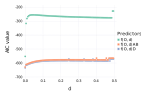

In [23]:
CWaic = plot(AV, x=:d_val, y=:AIC, color=:Predictors, Geom.point,
    Guide.ylabel("AIC value"),
    Guide.xlabel("<i>d</i>"),
    Scale.color_discrete_manual(gen_brew_colors(3)...),
    Theme(point_size=2.5pt, minor_label_font_size=10pt,
        major_label_font_size=14pt,
        minor_label_color=colorant"black",
        major_label_color=colorant"black",
        key_title_font_size=13pt,
        key_label_font_size=11pt,
        key_label_color=colorant"black",
        key_title_color=colorant"black",
        highlight_width=0.25pt))

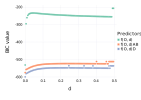

In [24]:
CWbic = plot(BV, x=:d_val, y=:BIC, color=:Predictors, Geom.point,
    Guide.ylabel("BIC value"),
    Guide.xlabel("<i>d</i>"),
    Scale.color_discrete_manual(gen_brew_colors(3)...),
    Theme(point_size=2.5pt, minor_label_font_size=10pt,
        major_label_font_size=14pt,
        minor_label_color=colorant"black",
        major_label_color=colorant"black",
        key_title_font_size=13pt,
        key_label_font_size=11pt,
        key_label_color=colorant"black",
        key_title_color=colorant"black",
        highlight_width=0.25pt))